In [1]:
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

import pickle
from src.preprocess.dataset import selective_segments

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="talk",style='whitegrid')

import numpy as np
import nilearn as nil
from nilearn import plotting
from nilearn.plotting import plot_glass_brain
import tensorflow as tf

# Methods

## Procedure & Visual Stimuli
- fMRI data was collected from 61 participants.
- Forty-five minutes of fMRI data was collected on every participant.
- Two circles moved around randomly on the projection screen. 
- When circles collided, a mild but unpleasant electric shock was delivered to the index and middle fingers of participant's left hand. 
- Shock delivery was only meant to induce fear of circle collision.
- Several events of "near-miss" occured at random times during the experiment. 
- Near-miss events are defined as those when the circles approach each other for at least 8 seconds, come very close (i.e., distance less than 1.5 times the circle diameter), but miss and start to retreat, again, at least for 8 seconds.
- Near-miss events were included to investigate brain's dynamic response to approaching and retreating threats.

In [2]:
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/RUhoOgjJqlo??rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

## Preprocessing
- fMRI timeseries data suffers from a lot of noise such as,
    - Physiological signals associated with respiratory and cardiac cycles.
    - Head motion.
    - Scanner noise (drifts).
- These noise were filtered out using ICA (https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/).

## Training Data
- Out of the 45 minute long timeseries data, "segments" corresponding to near-miss events were extracted.
- Each segment was 14 timepoints long (14 x 1.25 = 17.5 seconds): first 7 timepoints corresponded to **approach**, and later 7 to **retreat**. 
- Every participant had 46 segments. That is, approximately 13 out 45 minutes of data was used for training a predictive model.
- Following is an example of a segment from the parietal cortex of the brain.

In [3]:
## Load the data
DATPAT = "../../data/processed/00a-ROI316_withShiftedSegments.pkl"
with open(DATPAT,"rb") as f:
    SEGMENTS=pickle.load(f)
    
roi_idx = 108
dataset=selective_segments(SEGMENTS,5)
roi = dataset['CON054']['data'][:,roi_idx,0]

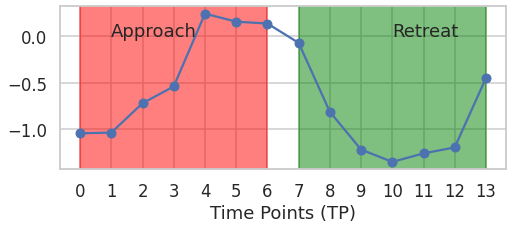

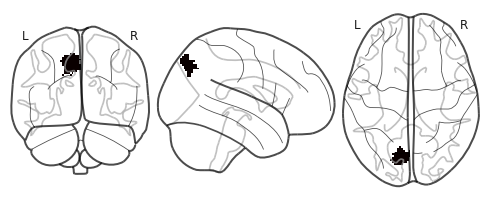

In [4]:
plt.figure(figsize=(8,3))
plt.plot(np.arange(14),roi,marker='o')
plt.axvspan(0,6,color='red',alpha=0.5)
plt.axvspan(7,13,color='green',alpha=0.5)
plt.text(1,0,'Approach',fontdict={'size':18})
plt.text(10,0,'Retreat',fontdict={'size':18})
#_=plt.xticks(np.arange(14)*1.25, labels=['TR{:02d}'.format(tr) for tr in np.arange(14)],rotation=90)
_=plt.xticks(np.arange(14))
_=plt.xlabel('Time Points (TP)')

mask = nil.image.load_img("../../data/processed/masks/00b-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz")
roi_mask = np.zeros_like(mask.get_fdata())
roi_mask[mask.get_fdata() == roi_idx] = 1.
roi_mask = nil.image.new_img_like(mask, roi_mask)
#plotting.view_img(roi_mask,symmetric_cmap=False,vmax=1)
plot_glass_brain(roi_mask)

- Training segments from a total of 316 brain regions were extracted in a similar fashion.
- Following figure shows all the 316 brain regions of interest (ROI). 

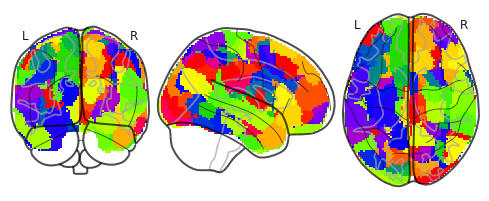

In [5]:
#plotting.view_img(mask,symmetric_cmap=False,vmax=300, draw_cross=True,black_bg=True)
plot_glass_brain(mask,cmap='prism')

- Every segment was divided into two training examples and labeled accordingly as follows:

                             <----------- Timeseries --------------->       Label  
        training example 1: [TP00, TP01, TP02, TP03, TP04, TP05, TP06] -> "approach"  
        training example 2: [TP07, TP08, TP09, TP10, TP11, TP12, TP13] -> "retreat" 
        
        
- Out of 61 participants, only 42 participants' data was used to train and validate the model. Remaining 19 participants data was used to test the model.

## Model

<img src="../../support/images/model.png" alt="fMRI data" height="250"/>

A variant of Long-Short Term Memory (LSTM), Gated Recurrent Units (GRU) architecture was emplyed to characterize the spatio-temporal pattern in the fMRI data. 

The GRU architecture had three hidden layers, each with 16 GRU units, and an ouput time-distributed, dense layer (DL) with single unit. The time-distributed DL returned prediction at every timepoint. Following was the model architecture:

In [6]:
model = tf.keras.models.load_model('../../models/01-ROI316_last_segment/CustomGRU.h5')

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 16)          16032     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
gru_2 (GRU)                  (None, None, 16)          1632      
_________________________________________________________________
time_distributed (TimeDistri (None, None, 1)           17        
Total params: 19,313
Trainable params: 19,313
Non-trainable params: 0
_________________________________________________________________
